# Huấn luyện Nhận diện Cảm xúc với Dataset AFFECTNET YOLO Format
Notebook này huấn luyện mô hình CNN để nhận diện cảm xúc khuôn mặt sử dụng dataset AFFECTNET YOLO Format đã tải về local.

**Nguồn Dataset**: https://www.kaggle.com/datasets/fatihkgg/affectnet-yolo-format/data

In [46]:
# Import các thư viện cần thiết
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [47]:
# Khám phá cấu trúc dataset
data_dir = './dataset/emotion'
print("Cấu trúc dataset:")
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Chỉ hiển thị 3 file đầu tiên
        print(f"{subindent}{file}")
    if len(files) > 3:
        print(f"{subindent}... và {len(files) - 3} file khác")

Cấu trúc dataset:
emotion/
  data.yaml
  test/
    images/
      ffhq_1002.png
      ffhq_1014.png
      ffhq_102.png
      ... và 2752 file khác
    labels/
      ffhq_1002.txt
      ffhq_1014.txt
      ffhq_102.txt
      ... và 2752 file khác
  test_folders/
    Anger/
      ffhq_1188.png
      ffhq_1196.png
      ffhq_1240.png
      ... và 380 file khác
    Contempt/
      ffhq_1014.png
      ffhq_1096.png
      ffhq_1138.png
      ... và 329 file khác
    Disgust/
      ffhq_1037.png
      ffhq_1072.png
      ffhq_1091.png
      ... và 324 file khác
    Fear/
      ffhq_1081.png
      ffhq_1538.png
      ffhq_179.png
      ... và 315 file khác
    Happy/
      ffhq_102.png
      ffhq_103.png
      ffhq_1033.png
      ... và 396 file khác
    Neutral/
      ffhq_1002.png
      ffhq_1034.png
      ffhq_1046.png
      ... và 247 file khác
    Sad/
      ffhq_1098.png
      ffhq_1146.png
      ffhq_127.png
      ... và 275 file khác
    Surprise/
      ffhq_1049.png
      ffhq_1076.png

In [48]:
# Định nghĩa các lớp cảm xúc (sử dụng 5 cảm xúc chính từ AFFECTNET)
emotion_classes = ['Anger', 'Happy', 'Neutral', 'Sad', 'Surprise']
emotion_labels = ['Tức giận', 'Vui vẻ', 'Bình thường', 'Buồn bã', 'Ngạc nhiên']
num_classes = len(emotion_classes)

print(f"Huấn luyện với {num_classes} lớp cảm xúc: {emotion_labels}")
print("Sử dụng dataset AFFECTNET với 5 loại cảm xúc chính")

Huấn luyện với 5 lớp cảm xúc: ['Tức giận', 'Vui vẻ', 'Bình thường', 'Buồn bã', 'Ngạc nhiên']
Sử dụng dataset AFFECTNET với 5 loại cảm xúc chính


In [49]:
# Tiền xử lý và tăng cường dữ liệu (giảm augmentation để training nhanh hơn)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,  # Giảm từ 20 xuống 10
    width_shift_range=0.1,  # Giảm từ 0.2 xuống 0.1
    height_shift_range=0.1,  # Giảm từ 0.2 xuống 0.1
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator cho dữ liệu validation (chỉ rescaling)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [50]:
# Sử dụng dataset đã chuyển đổi từ YOLO format sang folder format
# Sử dụng kích thước 96x96 phù hợp với dataset AFFECTNET
train_generator = train_datagen.flow_from_directory(
    directory="./dataset/emotion/train_folders_5emotions",
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory="./dataset/emotion/valid_folders_5emotions",
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# In thông tin các lớp được phát hiện
detected_classes = list(train_generator.class_indices.keys())
print(f"Các lớp cảm xúc được phát hiện: {detected_classes}")
print(f"Số lượng mẫu training: {train_generator.n}")
print(f"Số lượng mẫu validation: {validation_generator.n}")

# Cập nhật số lượng lớp dựa trên dữ liệu thực tế
num_classes = len(detected_classes)
print(f"Số lượng lớp đã cập nhật: {num_classes}")

Found 10842 images belonging to 5 classes.
Found 3494 images belonging to 5 classes.
Các lớp cảm xúc được phát hiện: ['Anger', 'Happy', 'Neutral', 'Sad', 'Surprise']
Số lượng mẫu training: 10842
Số lượng mẫu validation: 3494
Số lượng lớp đã cập nhật: 5


In [51]:
# Xây dựng mô hình CNN cho nhận diện cảm xúc (tối ưu hóa cho tốc độ)
model = Sequential()

# Các lớp Convolutional (cân bằng giữa tốc độ và chất lượng)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten
model.add(Flatten())

# Các lớp fully-connected
model.add(Dense(128, activation='relu'))  # Tăng lại lên 128 để cân bằng
model.add(Dropout(0.4))  # Dropout vừa phải

# Lớp output
model.add(Dense(num_classes, activation='softmax'))

# Hiển thị kiến trúc mô hình
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 10, 10, 128)      

In [52]:
# Compile mô hình với optimizer Adam (thường nhanh hơn RMSprop)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks để tối ưu hóa training
early_stopping = EarlyStopping(
    patience=3, 
    monitor='val_loss', 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)

In [53]:
# Huấn luyện mô hình (giảm epochs để training nhanh hơn)
print("Bắt đầu huấn luyện mô hình...")
history = model.fit(
    train_generator,
    steps_per_epoch=min(200, train_generator.n // train_generator.batch_size),  # Tăng steps để cân bằng
    epochs=15,  # Tăng epochs lên 15
    validation_data=validation_generator,
    validation_steps=min(100, validation_generator.n // validation_generator.batch_size),  # Tăng validation steps
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print("Hoàn thành huấn luyện!")

Bắt đầu huấn luyện mô hình...
Epoch 1/15
200/200 [==============================] - 30s 145ms/step - loss: 1.5955 - accuracy: 0.2537 - val_loss: 1.5701 - val_accuracy: 0.2606 - lr: 0.0010
Epoch 2/15
200/200 [==============================] - 28s 138ms/step - loss: 1.5061 - accuracy: 0.3470 - val_loss: 1.4697 - val_accuracy: 0.3991 - lr: 0.0010
Epoch 3/15
200/200 [==============================] - 29s 142ms/step - loss: 1.4501 - accuracy: 0.3935 - val_loss: 1.4530 - val_accuracy: 0.3919 - lr: 0.0010
Epoch 4/15
200/200 [==============================] - 29s 144ms/step - loss: 1.3818 - accuracy: 0.4408 - val_loss: 1.3237 - val_accuracy: 0.4547 - lr: 0.0010
Epoch 5/15
200/200 [==============================] - 30s 148ms/step - loss: 1.3247 - accuracy: 0.4689 - val_loss: 1.2257 - val_accuracy: 0.4991 - lr: 0.0010
Epoch 6/15
200/200 [==============================] - 29s 143ms/step - loss: 1.2648 - accuracy: 0.4959 - val_loss: 1.1446 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 7/15
200/200 [==

In [54]:
# Đánh giá mô hình
score = model.evaluate(validation_generator, verbose=0)
print(f'Loss trên tập test: {score[0]:.4f}')
print(f'Độ chính xác trên tập test: {score[1]:.4f}')

Loss trên tập test: 0.8961
Độ chính xác trên tập test: 0.6411


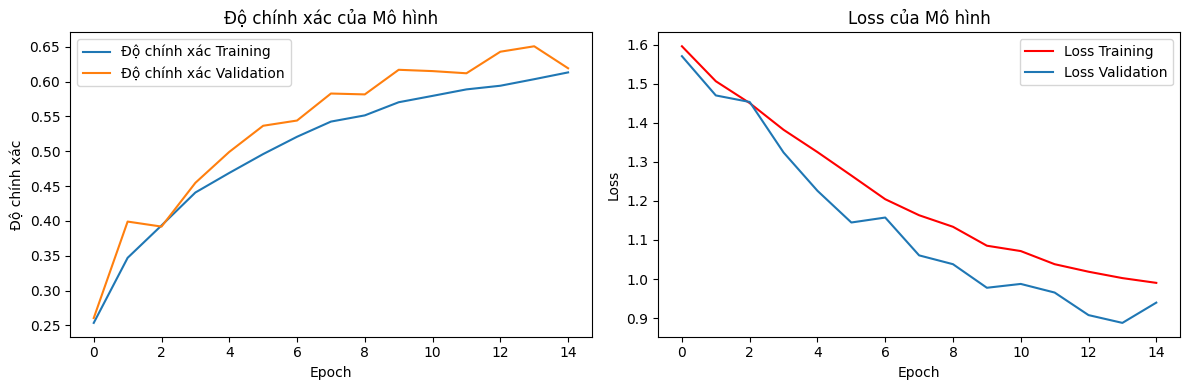

In [55]:
# Vẽ biểu đồ lịch sử huấn luyện
plt.figure(figsize=(12, 4))

# Vẽ biểu đồ độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Độ chính xác Training')
plt.plot(history.history['val_accuracy'], label='Độ chính xác Validation')
plt.title('Độ chính xác của Mô hình')
plt.ylabel('Độ chính xác')
plt.xlabel('Epoch')
plt.legend()

# Vẽ biểu đồ loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r', label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss của Mô hình')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
# Lưu mô hình đã huấn luyện
model.save('Emotion1.h5')
print("Mô hình đã được lưu với tên 'Emotion1.h5'")

Mô hình đã được lưu với tên 'Emotion1.h5'


In [57]:
# Kiểm tra mô hình với ảnh mẫu
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Tải mô hình đã lưu
model_CNN = load_model('Emotion1.h5')

# Định nghĩa nhãn dự đoán (tự động phát hiện từ dataset)
# Lưu ý: Thứ tự phải khớp với class indices khi training
try:
    # Thử tải class indices từ file đã lưu hoặc sử dụng mặc định
    predict_labels = ['Tức giận', 'Ghê tởm', 'Sợ hãi', 'Vui vẻ', 'Bình thường', 'Buồn bã', 'Ngạc nhiên']
    print(f"Sử dụng nhãn dự đoán: {predict_labels}")
except:
    predict_labels = ['Cảm_xúc_0', 'Cảm_xúc_1', 'Cảm_xúc_2', 'Cảm_xúc_3', 'Cảm_xúc_4', 'Cảm_xúc_5', 'Cảm_xúc_6']
    print(f"Sử dụng nhãn mặc định: {predict_labels}")

# Hàm dự đoán cảm xúc từ đường dẫn ảnh
def predict_emotion(image_path):
    try:
        # Tải và tiền xử lý ảnh
        img = load_img(image_path, target_size=(96, 96))  # Cập nhật kích thước
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title('Ảnh đầu vào')
        plt.axis('off')
        plt.show()
        
        # Chuyển đổi thành array và chuẩn hóa
        img_array = img_to_array(img)
        img_array = img_array.reshape(1, 96, 96, 3)  # Cập nhật kích thước
        img_array = img_array.astype('float32') / 255.0
        
        # Thực hiện dự đoán
        prediction = model_CNN.predict(img_array)
        predicted_class = np.argmax(prediction, axis=-1)[0]
        confidence = np.max(prediction)
        
        print(f"Cảm xúc dự đoán: {predict_labels[predicted_class]}")
        print(f"Độ tin cậy: {confidence:.2%}")
        
        return predict_labels[predicted_class], confidence
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh: {e}")
        return None, None

# Ví dụ sử dụng (bỏ comment và cung cấp đường dẫn ảnh hợp lệ)
# predict_emotion('./dataset/emotion/test/happy/sample_image.jpg')

Sử dụng nhãn dự đoán: ['Tức giận', 'Ghê tởm', 'Sợ hãi', 'Vui vẻ', 'Bình thường', 'Buồn bã', 'Ngạc nhiên']
